Fit interpretable models to the training set and test on validation sets.

In [97]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle as pkl
from os.path import join as oj

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree

import imodels
from rulevetting.api import validation
from rulevetting.projects.tbi_pecarn.dataset import Dataset

MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)

outcome_def = 'outcome'  # output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
df_train, df_tune, df_test = Dataset().get_data(load_csvs = False)
X_train = df_train.drop(columns=outcome_def)
y_train = df_train[outcome_def].values
X_test = df_test.drop(columns=outcome_def)
y_test = df_test[outcome_def].values
X_tune = df_tune.drop(columns=outcome_def)
y_tune = df_tune[outcome_def].values
processed_feats = df_train.keys().values.tolist()

feature_names = X_train.columns
def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

kwargs {'clean_data': {}, 'preprocess_data': {'frac_missing_allowed': 0.1, 'imputation': 'median'}, 'extract_features': {}}


# fit simple models

**decision tree**

100%|██████████████████████████████████████████| 59/59 [00:00<00:00, 59.22it/s]


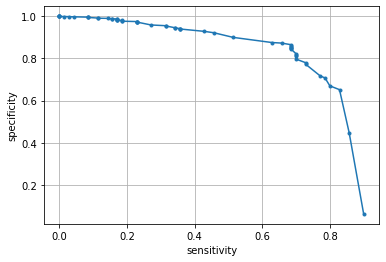

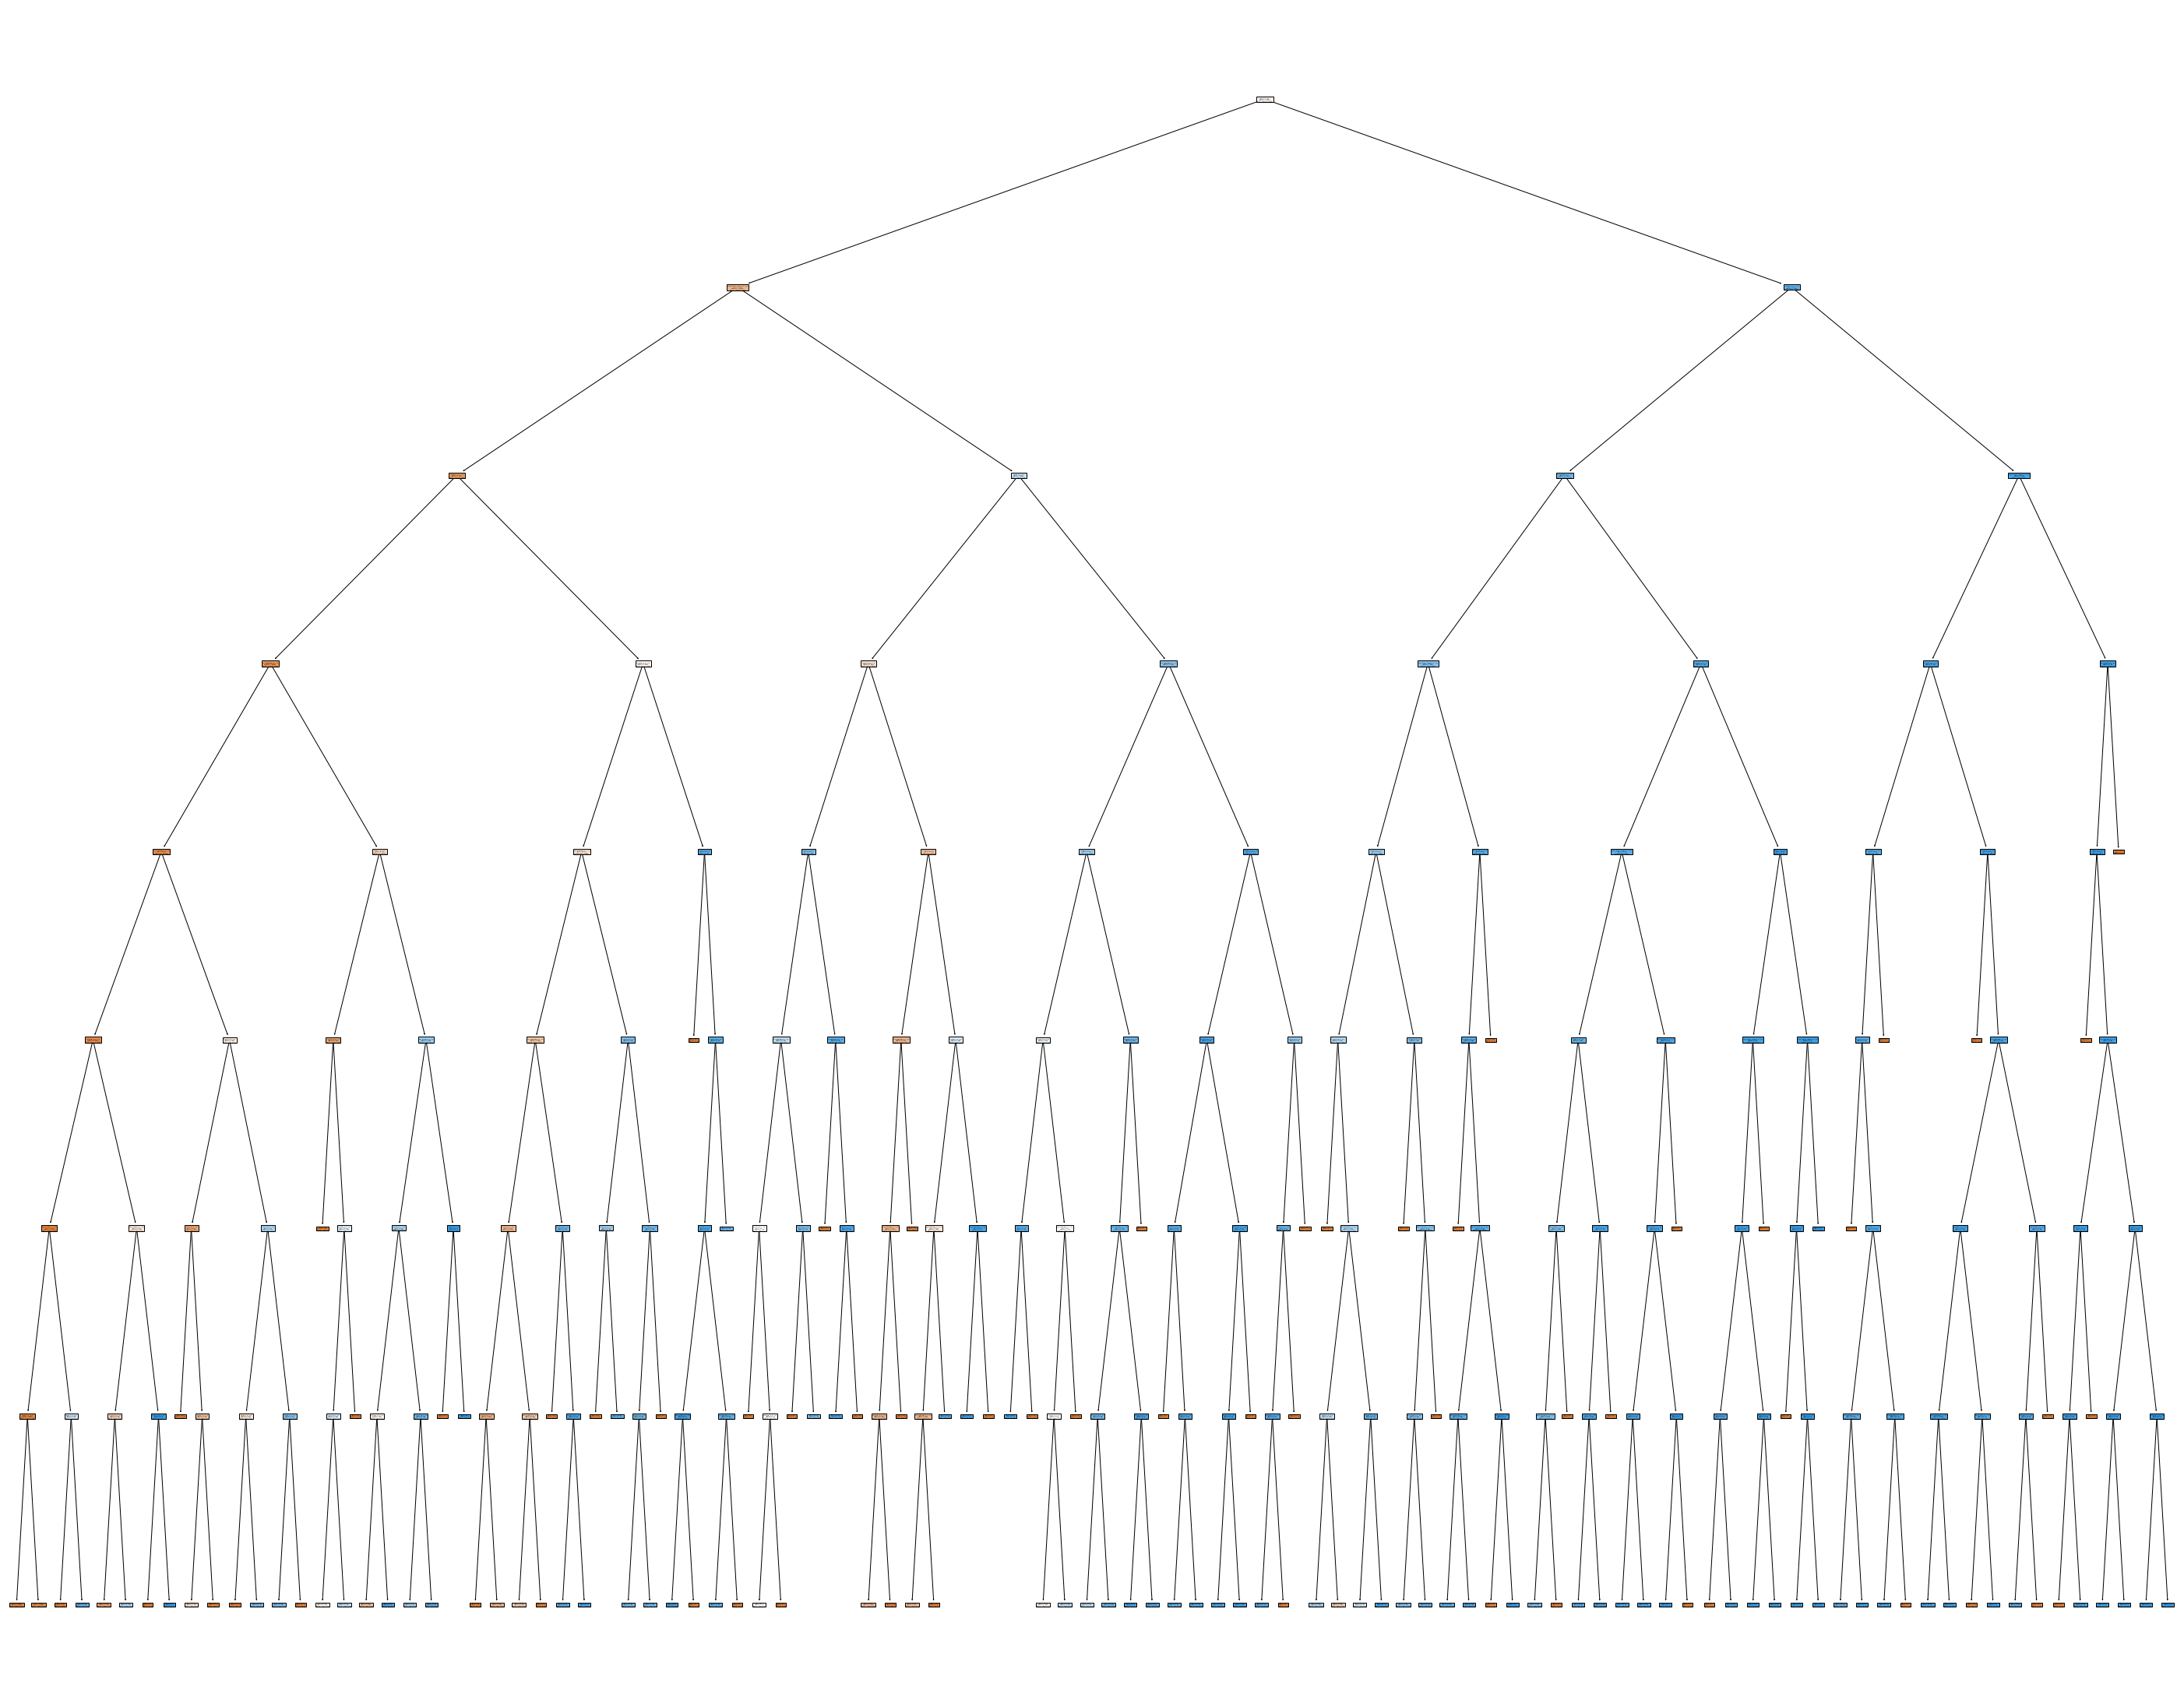

<Figure size 432x288 with 0 Axes>

In [162]:
from sklearn import tree
# fit decition tree
dt = DecisionTreeClassifier(max_depth=8, class_weight={0: 1, 1: 1e2})
dt.fit(X_train, y_train)
stats, threshes = predict_and_save(dt, model_name='decision_tree')
# plt.xlim((0.8, 1.0))
# plt.ylim((0.5, 1.0))
plt.show()

fig = plt.figure(figsize=(100, 100))
plot_tree(dt, feature_names=feature_names, filled=True)
plt.show()
tree.export_graphviz(dt, feature_names= feature_names,
                    class_names=["no PosIntFinal", "PosIntFinal"]
                                ,filled=True
                                ,rounded=True
                     ,out_file='tree.dot')
plt.savefig('../../../projects/tbi_pecarn/figs/decision_tree')

In [188]:
import sklearn.tree as sktree
predictors = ['NeuroDOth_1', 'AMS_1', 'GCSMotor_6', 'Hema_1', 'LOCSeparate_1',
       'LOCSeparate_2', 'High_impact_InjSev_3', 'HAStart_2', 'HAStart_92',
       'HemaLoc_3', 'VomitNbr_3', 'LocLen_92', 'NeuroDCranial_1']
r = sktree.export_text(dt, feature_names=predictors)
print(r)

|--- AMS_1 <= 0.50
|   |--- High_impact_InjSev_3 <= 0.50
|   |   |--- HemaLoc_3 <= 0.50
|   |   |   |--- LOCSeparate_1 <= 0.50
|   |   |   |   |--- LOCSeparate_2 <= 0.50
|   |   |   |   |   |--- VomitNbr_3 <= 0.50
|   |   |   |   |   |   |--- NeuroDOth_1 <= 0.50
|   |   |   |   |   |   |   |--- Hema_1 <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- Hema_1 >  0.50
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- NeuroDOth_1 >  0.50
|   |   |   |   |   |   |   |--- Hema_1 <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- Hema_1 >  0.50
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- VomitNbr_3 >  0.50
|   |   |   |   |   |   |--- NeuroDOth_1 <= 0.50
|   |   |   |   |   |   |   |--- HAStart_2 <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- HAStart_2 >  0.50
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |

In [149]:
## Cross validation: select tree depth
from sklearn.model_selection import cross_val_score
for i in range(5, 15):
    dt_i = DecisionTreeClassifier(max_depth=i, class_weight={0: 1, 1: 1e2})
    dt_i.fit(X_train, y_train)
    scores_i = cross_val_score(dt_i, X_train, y_train, cv=5)
    print(i, scores_i, np.mean(scores_i))
    
    
scores = cross_val_score(dt, X_test, y_test, cv=5)
scores

5 [0.84932642 0.83108808 0.81326425 0.76621762 0.79170984] 0.810321243523316
6 [0.82238342 0.82528497 0.80290155 0.82984456 0.78839378] 0.8137616580310881
7 [0.82507772 0.83378238 0.81098446 0.81803109 0.79564767] 0.8167046632124354
8 [0.84766839 0.85699482 0.82259067 0.83440415 0.81284974] 0.8349015544041452
9 [0.85720207 0.85637306 0.82466321 0.84974093 0.80373057] 0.838341968911917
10 [0.85989637 0.86279793 0.82735751 0.85015544 0.81761658] 0.8435647668393781
11 [0.85430052 0.86549223 0.82963731 0.85202073 0.8188601 ] 0.8440621761658033
12 [0.85367876 0.86549223 0.82984456 0.85222798 0.82031088] 0.8443108808290155
13 [0.85388601 0.86549223 0.82984456 0.85222798 0.82031088] 0.8443523316062176
14 [0.85388601 0.86549223 0.82963731 0.85222798 0.82010363] 0.8442694300518134


array([0.84854772, 0.91078838, 0.87344398, 0.89834025, 0.84615385])

The cross validation shows that max_depth=10 is probably a good choice in terms of accuracy.

**bayesian rule list (this one is slow)**

training bayesian_rule_list...


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 58.56it/s]


Trained RuleListClassifier for detecting PosIntFinal
IF AMS_1 > 0.5 THEN probability of PosIntFinal: 4.5% (3.8%-5.2%)
ELSE IF High_impact_InjSev_3 > 0.5 THEN probability of PosIntFinal: 1.4% (1.0%-1.8%)
ELSE IF HAStart_2 > 0.5 and Hema_1 > 0.5 THEN probability of PosIntFinal: 1.0% (0.6%-1.5%)
ELSE IF GCSMotor_6 > 0.5 THEN probability of PosIntFinal: 0.2% (0.1%-0.2%)
ELSE IF Hema_1 > 0.5 THEN probability of PosIntFinal: 50.0% (2.5%-97.5%)
ELSE probability of PosIntFinal: 50.0% (2.5%-97.5%)



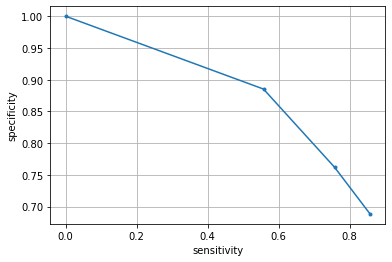

In [192]:
np.random.seed(13)
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training bayesian_rule_list...')
brl = imodels.BayesianRuleListClassifier(listlengthprior=6, max_iter=10000, class1label="PosIntFinal", verbose=False)
brl.fit(X_train, y_train, feature_names=feature_names)
stats, threshes = predict_and_save(brl, model_name='bayesian_rule_list')
print(brl)

In [181]:
print(brl)

Trained RuleListClassifier for detecting PosIntFinal
IF AMS_1 > 0.5 THEN probability of PosIntFinal: 4.5% (3.8%-5.2%)
ELSE IF High_impact_InjSev_3 > 0.5 and LocLen_92 > 0.5 THEN probability of PosIntFinal: 1.1% (0.8%-1.6%)
ELSE IF High_impact_InjSev_3 > 0.5 THEN probability of PosIntFinal: 4.3% (2.2%-6.9%)
ELSE IF HAStart_2 > 0.5 and Hema_1 > 0.5 THEN probability of PosIntFinal: 1.0% (0.6%-1.5%)
ELSE probability of PosIntFinal: 0.2% (0.1%-0.2%)



The results would not change much when we change the listlengthprior=5 to 2:9.

**rulefit**

100%|██████████████████████████████████████████| 35/35 [00:00<00:00, 54.40it/s]


'\ndef print_best(sens, spec):\n    idxs = np.array(sens) > 0.9\n    print(np.array(sens)[idxs], np.array(spec)[idxs])\nprint_best(sens, spec)\n'

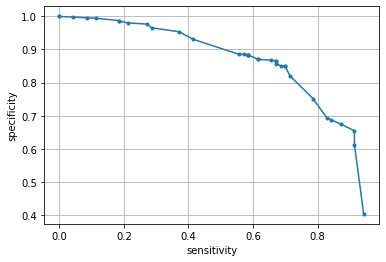

In [174]:
# fit a rulefit model
np.random.seed(13)
rulefit = imodels.RuleFitRegressor(max_rules=4)
rulefit.fit(X_train, y_train, feature_names=feature_names)

# preds = rulefit.predict(X_test)
stats, threshes = predict_and_save(rulefit, model_name='rulefit')
'''
def print_best(sens, spec):
    idxs = np.array(sens) > 0.9
    print(np.array(sens)[idxs], np.array(spec)[idxs])
print_best(sens, spec)
'''

In [175]:
# pd.reset_option('display.max_colwidth')
rules = rulefit.get_rules()

rules = rules[rules.coef != 0].sort_values("importance", ascending=False)

print(rules.head(15))

                                               rule    type      coef  \
1                                             AMS_1  linear  0.019083   
6                              High_impact_InjSev_3  linear  0.009454   
13               AMS_1 <= 0.5 and VomitNbr_3 <= 0.5    rule -0.007991   
9                                         HemaLoc_3  linear  0.008011   
14  NeuroDCranial_1 <= 0.5 and LOCSeparate_1 <= 0.5    rule -0.007239   
15                     AMS_1 > 0.5 and Hema_1 > 0.5    rule  0.005356   
3                                            Hema_1  linear  0.001244   
16                  AMS_1 > 0.5 and HemaLoc_3 > 0.5    rule  0.004736   

     support  importance  
1   1.000000    0.006394  
6   1.000000    0.003373  
13  0.836850    0.002953  
9   1.000000    0.002391  
14  0.898984    0.002182  
15  0.053140    0.001201  
3   1.000000    0.000609  
16  0.016373    0.000601  


**greedy (CART) rule list**

C:\Users\18723\rule-env\rule-env\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\18723\rule-env\rule-env\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 47.75it/s]


mean 0.009 (24125 pts)
if AMS_1 >= 1 then 0.044 (3109 pts)
mean 0.004 (21016 pts)
if High_impact_InjSev_3 >= 1 then 0.014 (3029 pts)
mean 0.002 (17987 pts)
if HemaLoc_3 >= 1 then 0.009 (1636 pts)
mean 0.002 (16351 pts)
if NeuroDOth_1 >= 1 then 0.031 (97 pts)
mean 0.001 (16254 pts)
if LOCSeparate_2 >= 1 then 0.009 (575 pts)
mean 0.001 (15679 pts)
if LOCSeparate_1 >= 1 then 0.006 (1312 pts)
mean 0.001 (14367 pts)
if VomitNbr_3 >= 1 then 0.006 (620 pts)
mean 0.001 (13747 pts)
if Hema_1 >= 1 then 0.001 (4888 pts)
mean 0.0 (8859 pts)
if HAStart_92 >= 1 then 0.0 (6825 pts)
mean 0.0 (2034 pts)



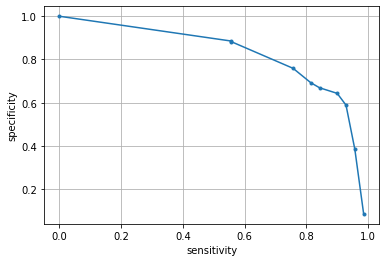

In [133]:
class_weight = {0: 1, 1: 100}
d = imodels.GreedyRuleListClassifier(max_depth=9, class_weight=class_weight, criterion='neg_corr')
d.fit(X_train, y_train, feature_names=feature_names, verbose=False)
stats, threshes = predict_and_save(d, model_name='grl')
# d.print_list()
print(d)

In [ ]:
# No need to select criterion 
#from sklearn.model_selection import KFold
# criterion = ['gini', 'entropy', 'neg_corr']
# kf = KFold(n_splits=5)

# for crt in criterion:
#    acc = []
#    for train, test in kf.split(X_train.index):
#        train_k = X_train.iloc[train]
#        train_y = y_train[train]
#        test_k = X_train.iloc[test]
#        test_y = y_train[test]
#        
#        d_crt = imodels.GreedyRuleListClassifier(max_depth=9, class_weight=class_weight, criterion=crt)
#        d_crt.fit(train_k, train_y, feature_names=feature_names, verbose=False)
#        preds_k = d_crt.predict(test_k)
#        acc_k = np.sum(preds_k == test_y)/len(test_y)
#        acc.append(acc_k)
#        print()
#    print(crt, acc, np.mean(acc))

**rf**

In [33]:
# # specify a decision tree with a maximum depth
# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)
# sens, spec, threshes = predict_and_save(rf, model_name='rf')
# # sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba[:, 1])
# imps = rf.feature_importances_.round(3)
# args = np.argsort(imps)
# imps = imps[args]
# feats = np.array(processed_feats)[args]
# for imp, feat in zip(imps, feats):
#     print(feat, imp)

# look at all the results

bayesian_rule_list.pkl
decision_tree.pkl
grl.pkl
rulefit.pkl
bayesian_rule_list.pkl
decision_tree.pkl
grl.pkl
rulefit.pkl


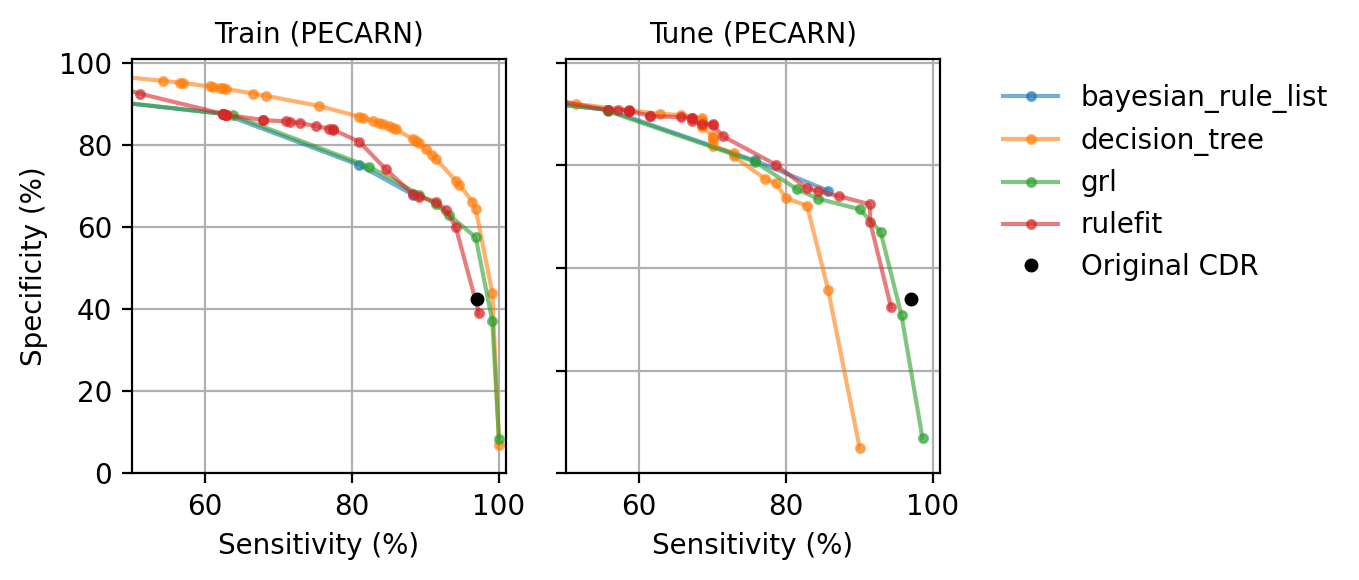

In [176]:
def plot_metrics(suffix, title=None, fs=15):
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                #         print(r)
                #                 print(r.keys())

                threshes = np.array(r['threshes' + suffix])
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                plt.plot(100 * sens, 100 * spec, 'o-', label=fname[:-4], alpha=0.6, markersize=3)
                plt.xlabel('Sensitivity (%)', fontsize=fs)
                plt.ylabel('Specificity (%)', fontsize=fs)
                s = suffix[1:]
                if title is None:
                    plt.title(f'{s}\n{data_sizes[s][0]} PosIntFinal / {data_sizes[s][1]}')
                else:
                    plt.title(title, fontsize=fs)

                # print best results
                if suffix == '_test2':
                    idxs = (sens > 0.95) & (spec > 0.43)
                    if np.sum(idxs) > 0:
                        idx_max = np.argmax(spec[idxs])
                        print(fname, f'{100 * sens[idxs][idx_max]:0.2f} {100 * spec[idxs][idx_max]:0.2f}')

    if suffix == '_test2':
        plt.plot(96.77, 43.98, 'o', color='black', label='Original CDR', ms=4)
    else:
        plt.plot(97.0, 42.5, 'o', color='black', label='Original CDR', ms=4)
    plt.grid()


suffixes = ['_train', '_tune']  # _train, _test1, _test2, _cv
titles = ['Train (PECARN)', 'Tune (PECARN)']
R, C = 1, len(suffixes)
plt.figure(dpi=200, figsize=(C * 2.5, R * 3), facecolor='w')
fs = 10
for i, suffix in enumerate(suffixes):
    ax = plt.subplot(R, C, i + 1)
    plot_metrics(suffix, title=titles[i], fs=fs)
    if i > 0:
        plt.ylabel('')
        plt.yticks([0, 25, 50, 75, 100], labels=[''] * 5)
    #         ax.yaxis.set_visible(False)
    plt.xlim((50, 101))
    plt.ylim((0, 101))
plt.tight_layout()
# plt.subplot(R, C, 1)
# plt.legend(fontsize=20)
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=fs, frameon=False)
plt.savefig('../../../projects/tbi_pecarn/figs/metrics_3_splits')
plt.show()

bayesian_rule_list.pkl


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 16.54it/s]


decision_tree.pkl


100%|██████████████████████████████████████████| 59/59 [00:03<00:00, 16.06it/s]


grl.pkl


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 17.22it/s]


rulefit.pkl


100%|██████████████████████████████████████████| 36/36 [00:02<00:00, 14.88it/s]


bayesian_rule_list.pkl


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 43.98it/s]


decision_tree.pkl


100%|██████████████████████████████████████████| 59/59 [00:01<00:00, 49.90it/s]


grl.pkl


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 54.64it/s]


rulefit.pkl


100%|██████████████████████████████████████████| 35/35 [00:00<00:00, 53.89it/s]


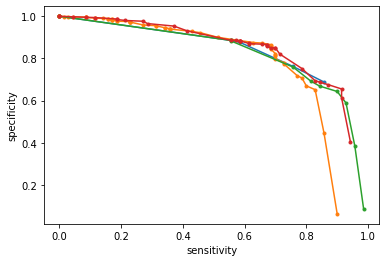

In [183]:
from rulevetting.api import validation
def print_metrics(suffix):
    vals = {s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-', 'brier_score', 'f1', 'acc', 'auc']}
    fnames = []
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                threshes = np.array(r['threshes' + suffix])
                m = r['model']

                # add more stats
                for x, y, suff in zip([X_train, X_tune],
                                      [y_train, y_tune],
                                      ['_train', '_tune']):
                    if suff == suffix:
                        stats, threshes = validation.all_stats_curve(y, m.predict_proba(x)[:, 1],
                                                                     plot=suffix == '_tune')
                        preds_proba = m.predict_proba(x)[:, 1]
                        brier_score = metrics.brier_score_loss(y, preds_proba)
                        
                # pick best vals
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                best_idx = np.argmax(5 * sens + spec)
                for k in vals.keys():
                    if not k == 'brier_score':
                        #                         print('k', k)
                        vals[k].append(stats[k][best_idx])
                vals['brier_score'].append(brier_score)
                fnames.append(fname[:-4])
    stats = pd.DataFrame.from_dict(vals)
    stats.index = fnames
    return (stats).round(2).transpose()


suffixes = ['_train', '_tune']  # _train, _test1, _test2
stats_list = {}
for i, suffix in enumerate(suffixes):
    stats_list[suffix] = print_metrics(suffix)

In [184]:
stats_list['_train']

,bayesian_rule_list,decision_tree,grl,rulefit
sens,0.88,0.97,0.97,0.94
spec,0.68,0.64,0.57,0.60
ppv,0.02,0.02,0.02,0.02
npv,1.00,1.00,1.00,1.00
lr+,2.75,2.72,2.28,2.35
lr-,0.17,0.05,0.06,0.10
brier_score,0.01,0.12,0.01,0.08
f1,0.05,0.05,0.04,0.04
acc,0.68,0.65,0.58,0.60
auc,0.83,0.92,0.86,0.87


In [186]:
stats_list['_tune']

,bayesian_rule_list,decision_tree,grl,rulefit
sens,0.86,0.83,0.93,0.91
spec,0.69,0.65,0.59,0.66
ppv,0.02,0.02,0.02,0.02
npv,1.00,1.00,1.00,1.00
lr+,2.75,2.38,2.26,2.65
lr-,0.21,0.26,0.12,0.13
brier_score,0.01,0.11,0.01,0.08
f1,0.05,0.04,0.04,0.04
acc,0.69,0.65,0.59,0.66
auc,0.81,0.78,0.83,0.84


In [202]:
if __name__ == '__main__':
    from rulevetting.projects.tbi_pecarn.dataset import Dataset
    from rulevetting.projects.tbi_pecarn import model_rules
    #df_train, df_tune, df_test = Dataset().get_data(load_csvs=True)
    df_full = pd.concat((df_train, df_tune, df_test))
    model = model_rules.ModelRules()
    preds_proba = model.predict_proba(df_full)
    print(model.print_model(df_full))

337.0 / 34576 (positive class / total)
	↓ 
If AMS_1                               → 177.0 / 4063 (4.4%)
	↓ 
   157.0 / 30299	 
If High_impact_InjSev_3                → 55.0 / 4025 (1.4%)
	↓ 
   99.0 / 26051	 
If HemaLoc_3                           → 19.0 / 2169 (0.9%)
	↓ 
   80.0 / 23764	 
If NeuroDOth_1                         → 3.0 /  120 (2.5%)
	↓ 
   77.0 / 23637	 
If LOCSeparate_2                       → 7.0 /  765 (0.9%)
	↓ 
   70.0 / 22818	 
If LOCSeparate_1                       → 10.0 / 1748 (0.6%)
	↓ 
   59.0 / 20982	 
If VomitNbr_3                          → 8.0 /  830 (1.0%)
	↓ 
   51.0 / 20107	 
If Hema_1                              → 7.0 / 6518 (0.1%)
	↓ 
   37.0 / 13207	 

